# Исследование об увеличении выручки интернет-магазина

Сотрудники интернет-магазина подготовили список гипотез для увеличения выручки. Целью данного исследования являются приоритезация гипотез, а также проведение анализа результатов А/В-теста для оценки эффективности изменений на веб-платформе/в бизнес-процессах. 

В рамках анализа будут изучены основные метрики, такие как средний чек, количество заказов и выручка, которые помогут определить влияние внедренных изменений на поведение пользователей. Для этого будет проведен сравнительный анализ двух групп - контрольной (группы А) и тестовой (группы В). Планируется изучение того как запланированные изменения могут повлиять на ключевые метрики, в результате чего будет сделано заключение о целесообразности дальнейшего проведения А/В-теста, а также внедрения планируемых изменений на постоянной основе. 

**Цель исследования:** проанализировать результаты А/В-теста и дать оценку эффективности изменений на веб-платформе/в бизнес-процессах.

**Задачи исследования:** 

- определить пригодность исходных данных для дальнейшего анализа, провести предобработку данных;
- применить фреймворки ICE и RICE для приоритезации гипотез, сравнить полученные результаты;
- определить кумулятивные выручку, количество заказов и средний чек по группам А/В-теста по имеющимся данным;
- определить наличие аномалий в данных, определить границы аномалий;
- провести рассчет статистической значимости различий в среднем количестве заказов на посетителя и среднем чеке по исходным и очищенным от аномалий данным;
- принять решение об успешности А/В-теста, необходимости его завершения либо продолжения. 

## Краткие выводы по результатам анализа

После удаления аномальных значений в исходных датафремах и по результатам теста Манна-Уитни можно сделать следующий вывод: 
- между группами А и В есть статистически значимая разница по среднему количеству заказов, но нет разницы в размере среднего чека. 

Пользователи группы В стали делать практически на 20% больше заказов по сравнению с пользователями группы А, однако к концу проведения теста их средний чек упал ниже среднего чека группы А.

В случае продолжения тестирования:
- при сохранении или увеличении размера среднего чека победителем окажется группа В, 
- в случае уменьшения среднего чека в группе В относительно группы А результаты могут сравняться либо группа А выйдет на первое место. 

## Обзор данных

Импортируем необходимые для проведения анализа данных библиотеки:

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import json

Прочитаем файлы `hypothesis.csv`, `orders.csv`, `visitors.csv` с данными (путь к данным храниться в файле формата json) и сохраним их в соответствующих переменных:

In [4]:
# Чтение JSON файла
with open('config.json', 'r', encoding='utf-8') as f:
    config = json.load(f)
 
# Чтение CSV файла с использованием пути из JSON
dataset_path_hypothesis = config['dataset_path_AB_hypothesis']
dataset_path_orders = config['dataset_path_AB_orders']
dataset_path_visitors = config['dataset_path_AB_visitors']
hypothesis = pd.read_csv(dataset_path_hypothesis)
orders = pd.read_csv(dataset_path_orders)
visitors = pd.read_csv(dataset_path_visitors)

Уберем ограничения при отображении количества столбцов, строк, ширины столбцов.

In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

Выведем первые строки каждого набора данных и общую информацию о каждом датафрейме.

In [7]:
# Функция для вывода первых 5 строк и информации о датафрейме
def display_data(df, df_name):
    print(f"Первые 5 строк датафрейма {df_name}:\n")
    print(df.head(5))
    print("\nИнформация о датафрейме:\n")
    print(df.info())
    print("\n" + "="*80 + "\n")

# Основная функция для вывода данных для 'users', 'subscriptions' и 'rides'
def main():
    display_data(hypothesis, 'hypothesis')
    display_data(orders, 'orders')
    display_data(visitors, 'visitors')

# Запускаем основную функцию
main()

Первые 5 строк датафрейма hypothesis:

                                                                                                     Hypothesis  \
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
3           Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар   
4                              Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей   

   Reach  Impact  Confidence  Efforts  
0      3      10           8        6  
1      2       5           4       10  
2      8       3           7        3  
3      8       3           3        8  
4      3       1           1        1  

Информация о датафрейме:

<cl

По начальным строкам каждого из датафреймов можно сделать вывод о том, что они содержат релевантные данные. Во всех датафреймах отсутствуют пропущенные значения. 

## Предобработка данных

Для дальнейшей работы приведем наименования столбцов в датафреймах к нижнему регистру, а также добавим нижнее подчеркивание между словами в названиях столбцов:

In [8]:
# Приведение к нижнему регистру:
hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = orders.columns.str.lower()

# Добавление нижнего подчеркивания:
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']

Столбцы датафреймов `orders` и  `visitors`, содержащие даты, имеют формат `object` и будут приведены к формату `datetime` в одной из дальнейших частей исследования. 

Проверим наличие явных дубликатов в датафреймах:

In [9]:
hypothesis.duplicated().sum()

0

In [10]:
orders.duplicated().sum()

0

In [11]:
visitors.duplicated().sum()

0

Явные пропуски и дубликаты в исходных данных не обнаружены, наименования столбцов датафреймов скорректированы. Отмечено  наличие различий в типе данных и их фактическом содержании в столбцах `date` датафреймов `orders` и `visitors`. Переходим к следующему этапу исследования. 

## Исследовательский анализ данных

### Приоритезация гипотез

В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort. Применим фреймворк ICE для приоритезации гипотез, отсортируем их по убыванию приоритета:

In [12]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis['ICE'] = hypothesis['ICE'].round(2)
hypothesis.sort_values(by = 'ICE', ascending = False)

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


Теперь применим фреймворк RICE для приоритезации гипотез и также отсортируем их по убыванию приоритета:

In [13]:
hypothesis['RICE'] = ((hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'])
hypothesis.sort_values(by='RICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


При применении фреймфорка ICE как наиболее перспективные отражаются гипотезы 8 "Запустить акцию, дающую скидку на товар в день рождения", 0 "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей" и 7 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок". Однако поскольку гипотеза 8 обладает минимальным охватом целевой аудитории при применении фреймворка RICE она выбывает из топ-3, в то время как добавляется гипотеза 2 с высоким показателем Reach. При применении обоих методов приоретизации гипотезы 7 и 0 - наиболее перспективны. 

### Анализ A/B-теста

Результаты A/B-теста содержатся в файлах /datasets/orders.csv и /datasets/visitors.csv. Проведем их детальный анализ.

#### График кумулятивной выручки по группам

In [14]:
# Приведем тип данных в столбцах date к datetime
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

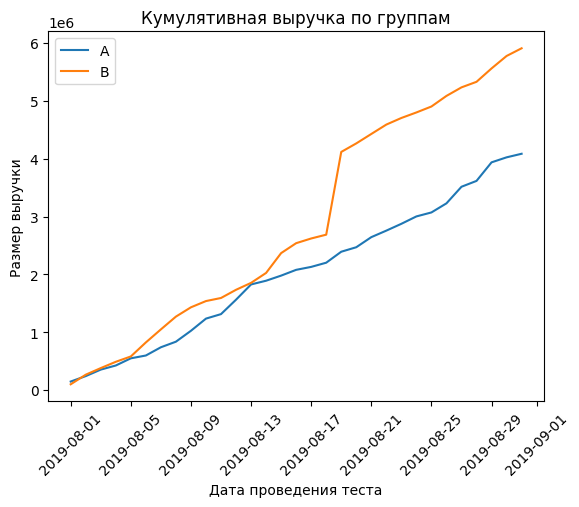

In [15]:
# Cоздаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# Получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])


# Получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

# Объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# Датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# Датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

# Поворот подписей по оси x
plt.xticks(rotation=45)

# Добавляем заголовок графика
plt.title('Кумулятивная выручка по группам')

# Добавляем подписи осей
plt.xlabel('Дата проведения теста')
plt.ylabel('Размер выручки')

plt.legend();

На протяжении всего времени проведения A/B-тестирования кумулятивная выручка группы B была выше, чем у группы А. Однако график выручки группы В резко растет в промежутке 18-19 августа 2019 г. Это может сигнализировать о наличии выбросов значений - всплеске числа заказов, либо о появлении очень дорогих заказов в выборке - которые могут существенно исказить результаты. 

#### График кумулятивного среднего чека по группам

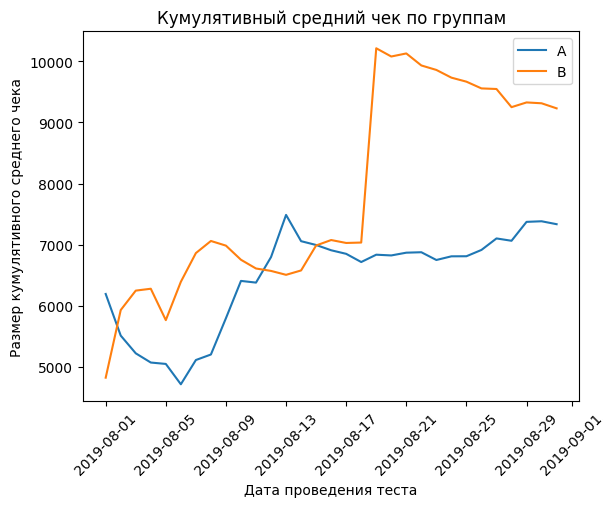

In [16]:
# Разделим кумулятивную выручку на кумулятивное число заказов
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

# Поворот подписей по оси x
plt.xticks(rotation=45)

# Добавляем заголовок графика
plt.title('Кумулятивный средний чек по группам')

# Добавляем подписи осей
plt.xlabel('Дата проведения теста')
plt.ylabel('Размер кумулятивного среднего чека')


plt.legend();

Средний чек группы В практически на всем протяжении теста выше, чем у группы А, однако в промежутке 18-19 августа 2019 г. (аналогично кумулятивной выручке) наблюдается колоссальный всплеск размера среднего чека. При этом если средний чек группы А становится практически равномерным начиная приблизительно с 14.08.2019, у группы В после всплеска наблюдается стабильный спад значения, вплоть до конца проведения эксперимента. 

#### График относительного изменения кумулятивного среднего чека группы B к группе A

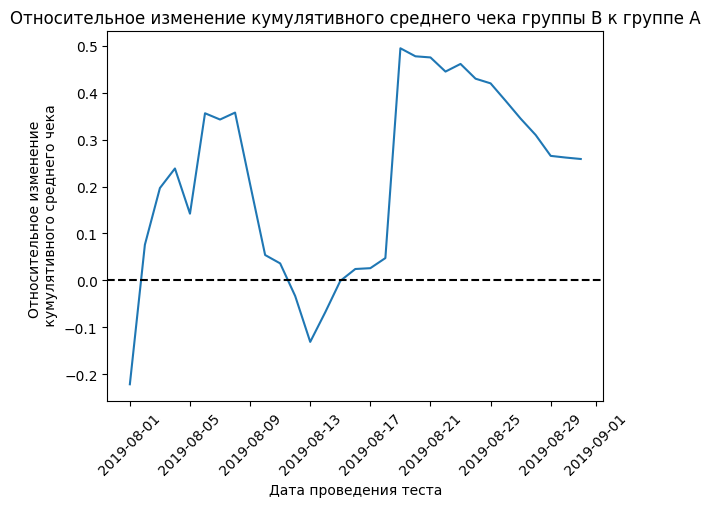

In [17]:
# Собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(
                            cumulativeRevenueB, 
                            left_on='date', 
                            right_on='date', 
                            how='left', 
                            suffixes=['A', 'B'])

# Строим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

# Поворот подписей по оси x
plt.xticks(rotation=45)

# Добавляем подписи осей
plt.xlabel('Дата проведения теста')
plt.ylabel('Относительное изменение \n кумулятивного среднего чека')

# Добавляем заголовок графика
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A');

На графике видны резкие колебания значений группы В относительно группы А. Поначалу результаты группы В росли относительно результатов группы А, однако с 09.08.2019 ситуация изменилась. Резкий рост также в интервале 18-19 августа 2019 г., как на предыдущих графиках, может свидетельствовать о наличии выбросов значений. 

#### График кумулятивного среднего количества заказов на посетителя по группам

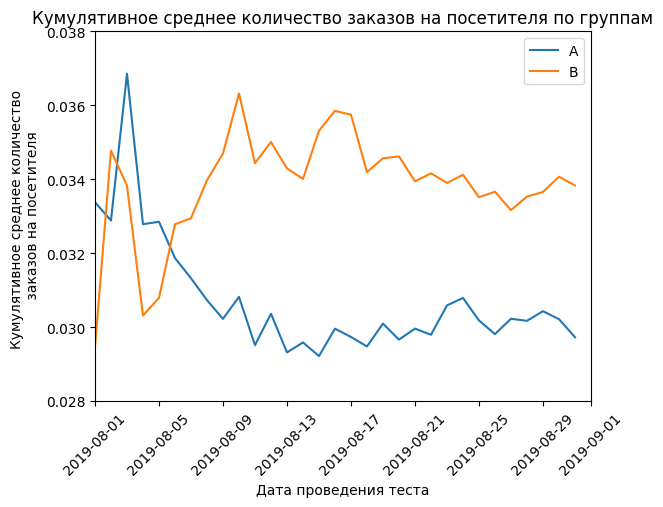

In [18]:
# Считаем среднее количество заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# Отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# Отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# Строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# Задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0.028, 0.038])

# Поворот подписей по оси x
plt.xticks(rotation=45)

# Добавляем подписи осей
plt.xlabel('Дата проведения теста')
plt.ylabel('Кумулятивное среднее количество \n заказов на посетителя')

# Добавляем заголовок графика
plt.title('Кумулятивное среднее количество заказов на посетителя по группам');

В начале теста сегмент A на протяжении недолгого времени имел большее кумулятивное среднее количество заказов, но постепенно сегмент B выровнялся и зафиксировался примерно около одного значения, больше значения сегмента A.

#### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

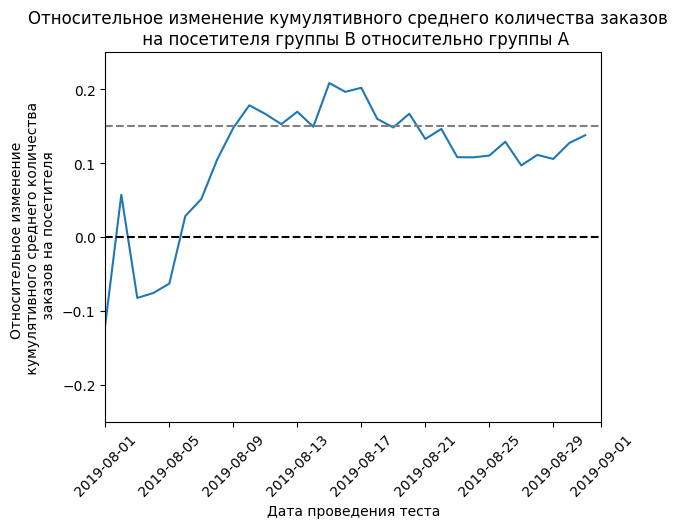

In [20]:
# Объединяем таблицы cumulativeDataA и cumulativeDataB
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
                              cumulativeDataB[['date','conversion']], 
                              left_on='date', 
                              right_on='date', 
                              how='left', 
                              suffixes=['A', 'B'])

# Строим график
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/
         mergedCumulativeConversions['conversionA']-1)


plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')

# Задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), -0.25, 0.25])

# Поворот подписей по оси x
plt.xticks(rotation=45)

# Добавляем подписи осей
plt.xlabel('Дата проведения теста')
plt.ylabel('Относительное изменение \n кумулятивного среднего количества \n заказов на посетителя')

# Добавляем заголовок графика
plt.title('Относительное изменение кумулятивного среднего количества заказов  \n на посетителя группы B относительно группы A');

В начале теста группа B проигрывала группе А, однако затем вырвалась вперед. Начиная с 09.08.2019 среднее количество заказов на посетителя для группы B выровнялось и приблизительно на 15% выше аналогичного показателя группы А.

#### Точечный график количества заказов по пользователям

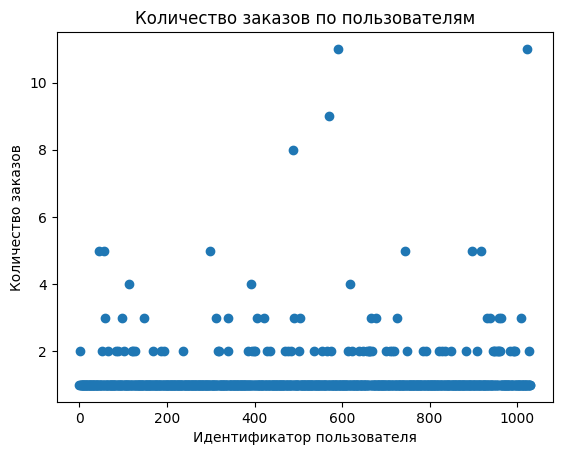

In [21]:
# Рассчитаем количество заказов для каждого пользователя 
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

# Переименуем колонки получившегося датафрейма
ordersByUsers.columns = ['visitor_id', 'orders']

# Серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))

# Построим точечный график
plt.scatter(x_values, ordersByUsers['orders']) 

# Добавляем подписи осей
plt.xlabel('Идентификатор пользователя')
plt.ylabel('Количество заказов')

# Добавляем заголовок графика
plt.title('Количество заказов по пользователям');

Пользователей, сделавших более двух заказов, относительно мало. Для определения того, какое число заказов является выбросом для данной выборки, далее рассчитаем перцентили количества заказов на пользователя. 

#### Расчет перцентилей количества заказов на пользователя

In [22]:
np.percentile(ordersByUsers['orders'], [90, 95, 99])

array([1., 2., 4.])

Только 1% посетителей делают 4 и более заказов и только 5% - 2 и более. Установим границу для определения аномальных пользователей по количеству заказов в районе более 2 заказов (>2). 

#### Точечный график стоимостей заказов

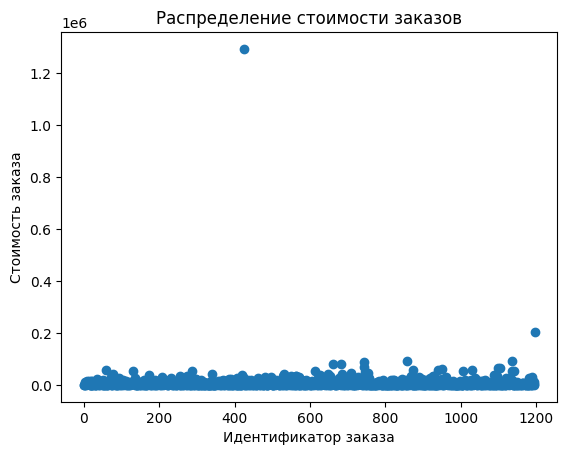

In [23]:
# Серия из чисел от 0 до количества наблюдений в orders['revenue']
x_values = pd.Series(range(0, len(orders['revenue'])))

# Построим точечный график
plt.scatter(x_values, orders['revenue'])

# Добавляем подписи осей
plt.xlabel('Идентификатор заказа')
plt.ylabel('Стоимость заказа')


# Добавляем заголовок графика
plt.title('Распределение стоимости заказов');

Согласно построенному графику встречаются только два аномальных значения стоимости заказов - один на сумму более 200 000 и один на сумму более миллиона. Такие значения определенно являются выбросами с учетом того, что стоимость оставшейся массы заказов не превышает 90 000. 

#### Расчет перцентилей стоимости заказов

In [24]:
np.percentile(orders['revenue'], [90, 95, 99])

array([18168. , 28000. , 58233.2])

Стоимость заказа 5% пользователей не превышает 28 000, а 1% - не более порядка 58 000. Поскольку аномальных значений, сильно выбивающихся из общего массива, всего два, установим границу для определения аномальных пользователей по стоимости заказа на уровне 60 000. Так мы отсечем менее 1% от всех пользователей. 

#### Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Сформулируем гипотезы. 

Нулевая: различий в среднем количестве заказов на посетителя между группами нет. 

Альтернативная: различия в среднем между группами есть.

In [25]:
# Рассчитаем ежедневное количество посетителей группы А 
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# Вычислим количество посетителей группы А в день накопленным итогом
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)

# Переименуем столбцы датафрейма
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

# Выполним аналогичные действия по группе В
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

# Рассчитаем ежедневное количество заказов пользователей группы А 
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)

# Переименуем столбцы датафрейма
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

# Вычислим количество заказов пользователей группы А в день накопленным итогом
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

# Переименуем столбцы датафрейма
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

# Выполним аналогичные действия по группе В
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

# Объединим датафреймы
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

# Определим количество заказов каждого пользователя из группы А
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)

# Переименуем столбцы датафрейма
ordersByUsersA.columns = ['userId', 'orders']

# Выполним аналогичные действия по группе В
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 

# Объявим переменную sampleA, в которой пользователям из группы А будет соответствовать количество их заказов. 
# (Тем, кто ничего не заказал, будут соответствовать нули.) 
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# Объявим аналогичную переменную sampleB для пользователей группы В
sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# Посчитаем статистическую значимость различия среднего количества заказов по результатам А/В-теста, 
# применив тест Манна-Уитни
print("Статистическая значимость различия среднего количества заказов по результатам А/В-теста:", 
      "{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

# Вычислим и выведим относительное различие в среднем между группами. 
print("Относительное различие в среднем между группами:", 
      "{0:.5f}".format(sampleB.mean() / sampleA.mean() - 1))

Статистическая значимость различия среднего количества заказов по результатам А/В-теста: 0.01679
Относительное различие в среднем между группами: 0.13808


По результатам проведения теста Манна-Уитни значение p-value составило около 0.017, что меньше 0.05, значит мы отвергаем нулевую гипотезу об отсутствии различий в среднем количестве заказов на посетителя между группами. 

Относительный прирост среднего группы B по отношению к показателю группы A равен 13.8%.

#### Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данными

Проверим статистическую значимость различий в среднем чеке между сегментами. 

Нулевая гипотеза: различий в среднем чеке между группами нет. 

Альтернативная гипотеза: различия в среднем чеке между группами есть. 

In [38]:
# Посчитаем статистическую значимость различий в среднем чеке заказа между группами
print("Статистическая значимость различий в среднем чеке заказа между группами:", 
      '{0:.5f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                          orders[orders['group']=='B']['revenue'])[1]))

# Выведим относительный прирост среднего чека группы B 
print("Относительный прирост среднего чека группы B:", 
      '{0:.5f}'.format(orders[orders['group']=='B']['revenue'].mean()/
                       orders[orders['group']=='A']['revenue'].mean()-1))

Статистическая значимость различий в среднем чеке заказа между группами: 0.72929
Относительный прирост среднего чека группы B: 0.25871


P-value составило около 0.73, что больше 0.05 — значит мы не отвергаем нулевую гипотезу и статистически значимых отличий в среднем чеке между группами нет. 

Однако относительное различие среднего чека между сегментами составило около 26%.

#### Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Ранее в качестве аномальных значений мы признали данные пользователей, которые сделали более двух заказов, а также тех, стоимость чьих заказов превысила 60 000.
Узнаем, сколько всего данных пользователей можно отнести к аномальным:

In [27]:
# Создаем датафрейм с информацией о пользователях, сделавших более 2 заказов
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)

# Создаем датафрейм с информацией о пользователях, стоимость заказов которых превысила 60 000
usersWithExpensiveOrders = orders[orders['revenue'] > 60000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print(abnormalUsers.shape[0]) 

30


Всего 30 аномальных пользователей. 
Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. 

Нулевая: различий в среднем количестве заказов на посетителя между группами нет. 

Альтернативная: различия в среднем между группами есть.

In [28]:
# Подготовим выборки количества заказов по пользователям по группам теста
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

# Применим статистический критерий Манна-Уитни к полученным выборкам
print("Статистическая значимость различия среднего количества заказов по результатам А/В-теста:", 
      '{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("Относительное различие в среднем между группами:",
      '{0:.5f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

Статистическая значимость различия среднего количества заказов по результатам А/В-теста: 0.00926
Относительное различие в среднем между группами: 0.17625


Статистическая значимость различия среднего количества заказов по результатам А/В-теста по очищенным данным составила 0.009, что значительно меньше 0.05, значит мы снова (как и в случае с неочищенными данными) отвергаем нулевую гипотезу об отсутствии различий в среднем количестве заказов на посетителя между группами.

Относительное различие в среднем между группами по очищенным данным возросло до 17,6%.

Можно сделать вывод о том, что выбросы не меняют принципиально результата анализа двух массивов данных и результаты группы В в части среднего количества заказов статистически значимо выше результатов группы А.

#### Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным

Нулевая гипотеза: различий в среднем чеке между группами нет. 

Альтернативная гипотеза: различия в среднем чеке между группами есть. 

In [29]:
# Посчитаем статистическую значимость различий в среднем чеке заказа между группами
print("Статистическая значимость различий в среднем чеке заказа между группами:", 
    '{0:.5f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

# Выведим относительный прирост среднего чека группы B 
print("Относительный прирост среднего чека группы B:", 
    "{0:.5f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

Статистическая значимость различий в среднем чеке заказа между группами: 0.83546
Относительный прирост среднего чека группы B: -0.00643


Поскольку p-value равен 0.84, мы не может отвергнуть нулевую гипотезу, то есть признаем отсутствие статически значимых различий в среднем чеке между группами. 

Относительный прирост среднего чека при анализе очищенных данных оказался крайне малым и отрицательным - всего -0.6%.

#### Принятие решения по результатам теста

Имеющиеся факты:

По среднему количеству заказов между группами и по «сырым» данным, и по данным после фильтрации аномалий статистически значимое различие присутствует.

По среднему чеку между группами нет статистически значимого различия ни по «сырым» данным, ни по данным после фильтрации аномалий.

График различия среднего количества заказов между группами сообщает, что результаты группы B были хуже группы А только в самом начале теста и на протяжении почти всего теста их превосходили стабильно и без колебаний. 

При этом график различия среднего чека не отражает такого стабильного результата и подвержен значительным колебаниям: за месяц наблюдений результат группы В в начале уступал результату группы А, затем показатели группы В росли до 09.08.2019, после чего начался резкий спад, когда результаты группы А превзошли результаты группы В, ситуацию для группы В в значительной степени исправили крупные заказы, постипившие 18-19 августа 2019 г., и представляющие из себя аномалии, с этого времени и до конца теста значения группы В неуклонно снижаются. 

Поскольку полученные результаты анализа А/В-теста противоречивы, рекомендуется продолжить его проведение. 

#### Повторное построение графиков по обработанным данным без аномалий

Для лучшего понимания результатов анализа уберем аномальные значения из исходного датафрейма и заново построим соответствующие графики:

In [30]:
orders2 = orders[np.logical_not(orders['visitor_id'].isin(abnormalUsers))]

**График кумулятивной выручки по группам**

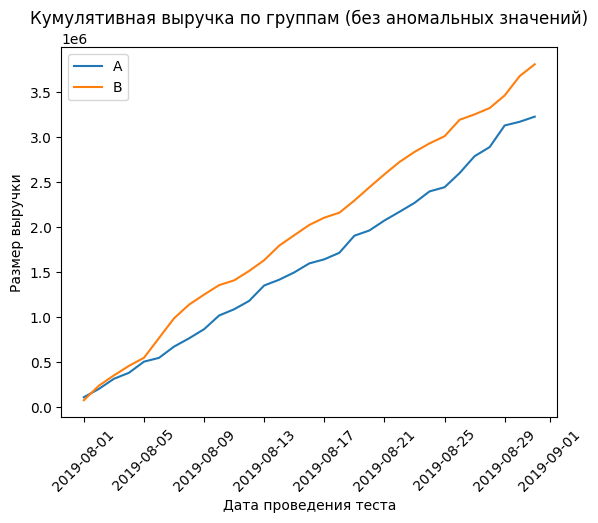

In [31]:
# Cоздаем массив уникальных пар значений дат и групп теста
datesGroups2 = orders2[['date','group']].drop_duplicates()

# Получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated2 = datesGroups2.apply(
    lambda x: orders2[
        np.logical_and(
            orders2['date'] <= x['date'], orders2['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])


# Получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated2 = datesGroups2.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

# Объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData2 = ordersAggregated2.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData2.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# Датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA2 = cumulativeData2[cumulativeData2['group']=='A'][['date','revenue', 'orders']]

# Датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB2 = cumulativeData2[cumulativeData2['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA2['date'], cumulativeRevenueA2['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB2['date'], cumulativeRevenueB2['revenue'], label='B')

# Поворот подписей по оси x
plt.xticks(rotation=45)

# Добавляем заголовок графика
plt.title('Кумулятивная выручка по группам (без аномальных значений)')

# Добавляем подписи осей
plt.xlabel('Дата проведения теста')
plt.ylabel('Размер выручки')

plt.legend();

**График кумулятивного среднего чека по группам**

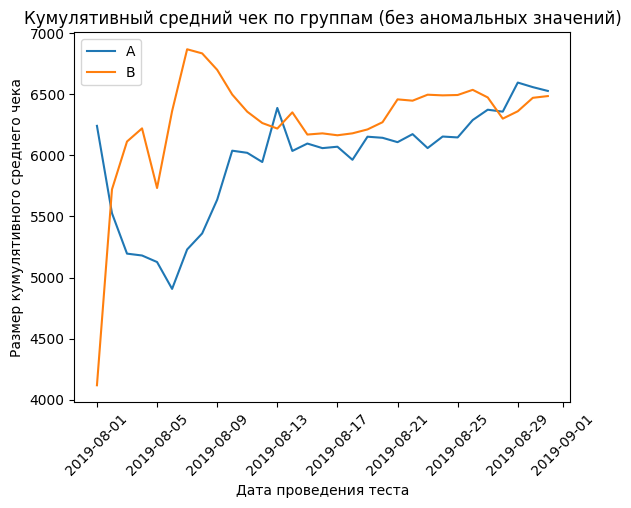

In [32]:
# Разделим кумулятивную выручку на кумулятивное число заказов
plt.plot(cumulativeRevenueA2['date'], cumulativeRevenueA2['revenue']/cumulativeRevenueA2['orders'], label='A')
plt.plot(cumulativeRevenueB2['date'], cumulativeRevenueB2['revenue']/cumulativeRevenueB2['orders'], label='B')

# Поворот подписей по оси x
plt.xticks(rotation=45)

# Добавляем заголовок графика
plt.title('Кумулятивный средний чек по группам (без аномальных значений)')

# Добавляем подписи осей
plt.xlabel('Дата проведения теста')
plt.ylabel('Размер кумулятивного среднего чека')

plt.legend();

**График относительного изменения кумулятивного среднего чека группы B к группе A**

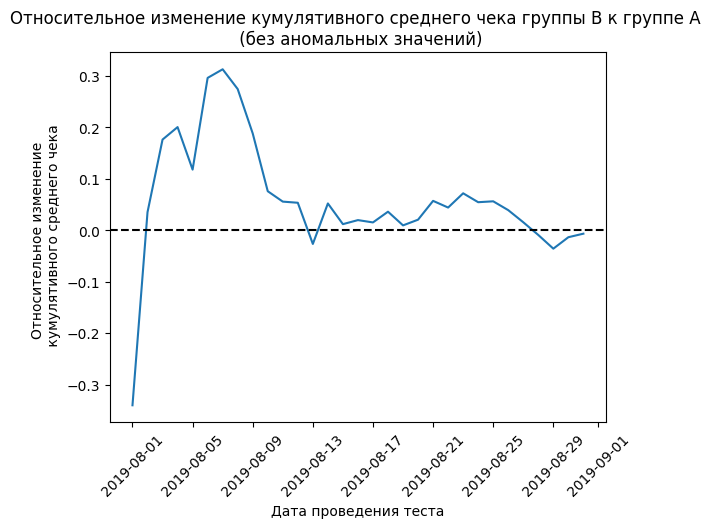

In [37]:
# Собираем данные в одном датафрейме
mergedCumulativeRevenue2 = cumulativeRevenueA2.merge(
                            cumulativeRevenueB2, 
                            left_on='date', 
                            right_on='date', 
                            how='left', 
                            suffixes=['A', 'B'])

# Строим отношение средних чеков
plt.plot(mergedCumulativeRevenue2['date'], (mergedCumulativeRevenue2['revenueB']/mergedCumulativeRevenue2['ordersB'])/
         (mergedCumulativeRevenue2['revenueA']/mergedCumulativeRevenue2['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

# Поворот подписей по оси x
plt.xticks(rotation=45)

# Добавляем подписи осей
plt.xlabel('Дата проведения теста')
plt.ylabel('Относительное изменение \n кумулятивного среднего чека')

# Добавляем заголовок графика
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A \n (без аномальных значений)');

**График кумулятивного среднего количества заказов на посетителя по группам**

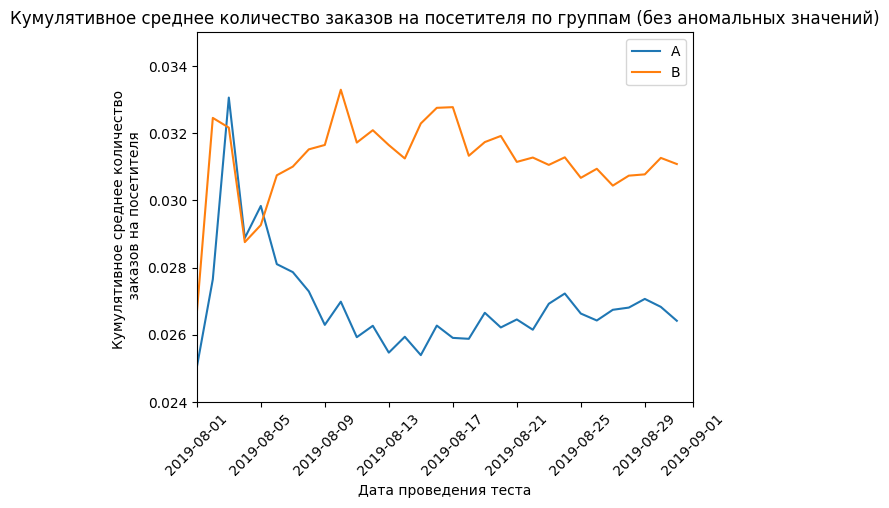

In [34]:
# Считаем среднее количество заказов на посетителя
cumulativeData2['conversion'] = cumulativeData2['orders']/cumulativeData2['visitors']

# Отделяем данные по группе A
cumulativeDataA2 = cumulativeData2[cumulativeData2['group']=='A']

# Отделяем данные по группе B
cumulativeDataB2 = cumulativeData2[cumulativeData2['group']=='B']

# Строим графики
plt.plot(cumulativeDataA2['date'], cumulativeDataA2['conversion'], label='A')
plt.plot(cumulativeDataB2['date'], cumulativeDataB2['conversion'], label='B')
plt.legend()

# Задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0.024, 0.035])

# Поворот подписей по оси x
plt.xticks(rotation=45)

# Добавляем подписи осей
plt.xlabel('Дата проведения теста')
plt.ylabel('Кумулятивное среднее количество \n заказов на посетителя')

# Добавляем заголовок графика
plt.title('Кумулятивное среднее количество заказов на посетителя по группам (без аномальных значений)');

**График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A**

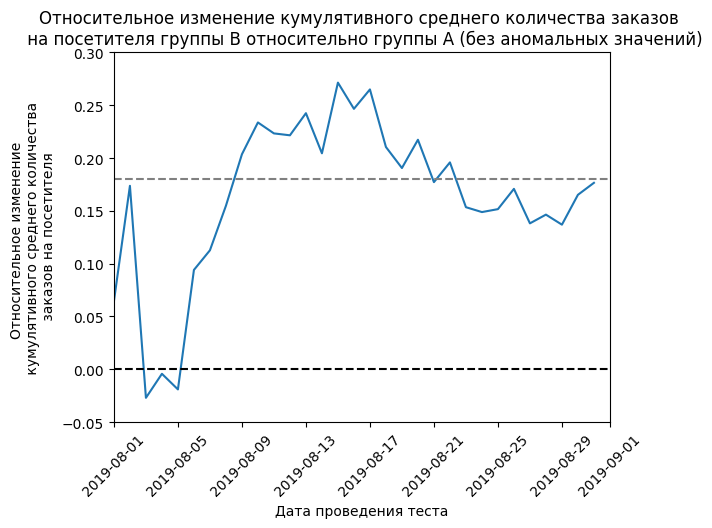

In [36]:
# Объединяем таблицы cumulativeDataA и cumulativeDataB
mergedCumulativeConversions2 = cumulativeDataA2[['date','conversion']].merge(
                              cumulativeDataB2[['date','conversion']], 
                              left_on='date', 
                              right_on='date', 
                              how='left', 
                              suffixes=['A', 'B'])

# Строим график
plt.plot(mergedCumulativeConversions2['date'], mergedCumulativeConversions2['conversionB']/
         mergedCumulativeConversions2['conversionA']-1)


plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.18, color='grey', linestyle='--')

# Задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), -0.05, 0.3])

# Поворот подписей по оси x
plt.xticks(rotation=45)

# Добавляем подписи осей
plt.xlabel('Дата проведения теста')
plt.ylabel('Относительное изменение \n кумулятивного среднего количества \n заказов на посетителя')

# Добавляем заголовок графика
plt.title('Относительное изменение кумулятивного среднего количества заказов \n на посетителя группы B относительно группы A (без аномальных значений)');

Можно сделать вывод о том, что, без учета аномальных данных, результаты А/В-теста показали: среднее количество заказов пользователей из группы В увеличилось практически на 20% по сравнению с группой А, однако кумулятивный средний чек группы В к концу теста упал ниже значения группы А. (При этом кумулятивный средний чек группы А имеет четкую тенденцию к стабильному росту, в то время как этот показатель группы В еще не стабилизировался.) 
За счет большего количества заказов и высокого среднего чека в начале тестирования группа В к концу наблюдений накопила большую кумулятивную выручку, чем группа А, однако разрыв не столь большой и если средний чек группы В продолжит падать относительно группы А, в дальнейшем показатели выручки могут сравняться и стать статистически не значимыми. 

##  Общий вывод

В целом по результатам исследования можно сказать, что исходные датафреймы отличаются полнотой и отсутствием явных дубликатов. 

При приоритезации гипотез путем применения фреймворков ICE и RICE получаются сходные результаты, однако при применении RICE наверх выходят гипотезы с высокой долей охвата аудитории/пользователей, что стоит учесть при выборе метода приоритезации. При применении обоих методов приоретизации наиболее перспективны гипотезы 7 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" и 0 "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей".

После определения и удаления аномальных значений в исходных датафремах, содержащих результаты А/В-теста, применения статистического критерия Манна-Уитни к полученным выборкам, можно сделать вывод о наличии статистически значимых различий между группами А и В по среднему количеству заказов и отсутствию статистически значимой разницы в размере среднего чека. 

Пользователи группы В стали делать практически на 20% больше заказов по сравнению с пользователями группы А, однако к концу проведения теста их средний чек упал ниже среднего чека группы А.

В случае продолжения тестирования, сохранения разницы в количестве заказов между группами:
- при сохранении или увеличении размера среднего чека однозначным победителем окажется группа В, 
- в случае уменьшения среднего чека в группе В относительно группы А результаты групп могут сравняться либо группа А выйдет на первое место. 